# **Proximal Policy Optimization Algorithm in discrete action space**
**Experimental Environment: [Pong](https://gym.openai.com/envs/Pong-v0/)**

**Coding Framework: Python3, PyTorch**

**Best Reward +16.800 in 3800 epochs (mean on 10 tests each 10 epochs):**
**[video](https://drive.google.com/file/d/1gBZcamkG91G4A_R9j5S2ctGlmKcHcPhV/view?usp=sharing)** **,** **[plot](https://drive.google.com/file/d/1Af2iSOpXRXpS1YNWwpwemZq-gIGnB3_k/view?usp=sharing)** **and** **[trained model](https://drive.google.com/open?id=1-C0bDhvu032GEBUN1hygm8_8O2XJmkq4)**

**UPDATE: Best Reward +17.400 in 4740 epochs (mean on 10 tests each 10 epochs):**
**[video](https://drive.google.com/file/d/1-8DLrU6y9BcJKiCsqUVeAFtBeDz4ATxJ/view?usp=sharing)** **,** **[plot](https://drive.google.com/file/d/1oMWD6gr8dUYZ9so4ZW3UeaSpHWu4O6Rx/view?usp=sharing)** **and** **[trained model](https://drive.google.com/open?id=1-0sXu2k1HKyIBkmNzwHfJcsB2X1sdgGB)**

**UPDATE: Best Reward +17.900 in 5660 epochs (mean on 10 tests each 10 epochs):**
**[video](https://drive.google.com/file/d/1-8DLrU6y9BcJKiCsqUVeAFtBeDz4ATxJ/view?usp=sharing)** **,** **[plot](https://drive.google.com/file/d/1oMWD6gr8dUYZ9so4ZW3UeaSpHWu4O6Rx/view?usp=sharing)** **and** **[trained model](https://drive.google.com/open?id=1-0sXu2k1HKyIBkmNzwHfJcsB2X1sdgGB)**

*Simone Rossetti*

 **1. Install required libraries**

In [0]:
!pip install gym # environmnet
!pip install torch # framework
!pip install Pillow # images
!apt-get install x11-utils # visualization
!pip install stable-baselines # multiple environment
!apt-get install -y xvfb python-opengl > /dev/null 2>&1 # visualization
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # visualization

**2. Dependencies**

In [0]:
import os
import PIL
import gym
import torch
import base64
import imageio
import numpy as np
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from pyvirtualdisplay import Display
from IPython.display import clear_output
from torch.distributions import Categorical
from IPython import display as ipythondisplay
from stable_baselines.common.vec_env import VecVideoRecorder, SubprocVecEnv

**3. Locate Google Drive directory to save models and progress**

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

**4. Initialize global variables and hyperparameters**

Some hyperparameters have been chosen according to PPO research paper (`E_CLIP`, `G_GAE`, `L_GAE`, `E_CLIP`, `C_2`), others according to some empirical tests. 

For instance, `L_RATE = 1e-4` with `ReLU` returns very bad performances, classifier immediatly classify all the states with the same action with probability 1, all others 0 (`L_RATE = 1e-4` with `Tanh` activation function for each layer gave very good results in very cheap time but in the middle of the training, the gradient exploded due to Tanh function); `L_RATE = 1e-6` with ReLU gives too slow training.

`C_1`  is lower compared to the one on the official PPO paper (`C_1 = 1`) because otherwise the classifier stucks in a single classification. 

`T`, `N`, `M` have been chosen according to minibatch size *M <= N T*.

`K` has been chosen to reach a good compromise between gradient updates and time requirements.


In [0]:
ENV_ID = "Pong-v0"
H_SIZE = 256 # hidden size, linear units of the output layer
L_RATE = 1e-5 # learning rate, gradient coefficient for CNN weight update
G_GAE = 0.99 # gamma param for GAE
L_GAE = 0.95 # lambda param for GAE
E_CLIP = 0.2 # clipping coefficient
C_1 = 0.5 # squared loss coefficient
C_2 = 0.01 # entropy coefficient
N = 8 # simultaneous processing environments
T = 256 # PPO steps 
M = 64 # mini batch size
K = 10 # PPO epochs
T_EPOCHS = 10 # each T_EPOCH 
N_TESTS = 10 # do N_TESTS tests 
TARGET_REWARD = 20
TRANSFER_LEARNING = True
PATH='/content/drive/My Drive/PPO_PONG/checkpoints/Pong-v0_+17.900_5660.dat'

**5. Define CNN model for discrete action space**

The input to the neural network consists in a batch (single or multiple) of *1 x 84 × 84* image produced by functions at point **7**. The first hidden layer convolves *16* filters *8 × 8* with stride *4* with the input image and applies a rectifier nonlinearity. The second hidden layer convolves *32* filters *4 × 4* with stride *2*, again followed by a rectifier nonlinearity. The final hidden layer is fully-connected and consists of *256* rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions are *6*.

The first network, the critic, evaluate the state. The second network, the actor, estimate the most probable action to pick in different states.

In [0]:
class CNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(CNN, self).__init__()
        self.critic = nn.Sequential(  # The “Critic” estimates the value function
            nn.Conv2d(in_channels=num_inputs,
                      out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,
                      out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=2592, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=1),
        )
        self.actor = nn.Sequential(  # The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients)
            nn.Conv2d(in_channels=num_inputs,
                      out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,
                      out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=2592, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=num_outputs),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value


**6. Define some useful functions**

In [0]:
display = Display(visible=0, size=(400, 300))
display.start() # initialize display to play last test environment

for func in [
             lambda:os.mkdir(os.path.join('.', 'PPO_PONG')),
             lambda: os.mkdir(os.path.join('.', 'PPO_PONG/checkpoints')),
             lambda: os.mkdir(os.path.join('.', 'PPO_PONG/records')),
             lambda: os.mkdir(os.path.join('.', 'PPO_PONG/plots'))
             ]: # create directories
   try:
       func()
   except Exception as error: 
       print (error)
       continue

def make_env():    # this function creates a single environment
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _thunk():
        env = gym.make(ENV_ID).env
        return env
    return _thunk

def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8) # prevent 0 fraction
    return x

def test_env(env, model, device):
    state = env.reset()
    state = grey_crop_resize(state)

    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        next_state = grey_crop_resize(next_state)
        state = next_state
        total_reward += reward
    return total_reward

def plot(train_epoch, rewards, save):
    clear_output(True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('%s: Epoch: %s -> Reward: %s' % (ENV_ID, train_epoch, test_rewards[-1]))
    fig = plt.ylabel('Reward')
    fig = plt.xlabel('Epoch')
    fig = plt.plot(test_rewards)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        get_fig.savefig('PPO_PONG/plots/%s_%d.png' % (ENV_ID, test_rewards[-1]))

def record_video(env_id, model, video_length=500, prefix='', video_folder='PPO_PONG/records/'):
  eval_env = SubprocVecEnv([lambda: gym.make(env_id)])
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  state = eval_env.reset() 
  state = grey_crop_resize_batch(state)
  for _ in range(video_length):
    state = torch.FloatTensor(state).to(device)
    dist, _ = model(state)
    action = dist.sample().cuda() if use_cuda else dist.sample()
    next_state, _, _, _ = eval_env.step(action.cpu().numpy())
    state = grey_crop_resize_batch(next_state)
  eval_env.close()

def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

[Errno 17] File exists: './PPO_PONG'
[Errno 17] File exists: './PPO_PONG/checkpoints'
[Errno 17] File exists: './PPO_PONG/records'
[Errno 17] File exists: './PPO_PONG/plots'


**7. Define functions to deal with observations**

Pong environment is *210 x 160 x 3* pixel (*H x W x C*) in *RGB* (*3 channels*).

To keep track of our environment the model needs consistent representation of the environment. Because of that, images have been reduced to a single channel (*greyscale*), then *cropped* along the playing area, *squared* and *reduced* by dimension. Resulting images of the states are *1 x 84 x 84* pixel (*C x H x W*). 

Channels have been shifted with respect to the axes because Convolutional Layers in PyTorch compute batch (*B*) of images in a different order (*B x C x H x W*).

In [0]:
def grey_crop_resize_batch(state):  # deal with batch observations
    states = []
    for i in state:
        img = Image.fromarray(i)
        grey_img = img.convert(mode='L')
        left = 0
        top = 34  # empirically chosen
        right = 160
        bottom = 194  # empiricallly chosen
        cropped_img = grey_img.crop((left, top, right, bottom)) # cropped image of above dimension
        resized_img = cropped_img.resize((84, 84))
        array_2d = np.asarray(resized_img)
        array_3d = np.expand_dims(array_2d, axis=0)
        array_4d = np.expand_dims(array_3d, axis=0)
        states.append(array_4d)
        states_array = np.vstack(states) # turn the stack into array
    return states_array # B*C*H*W

def grey_crop_resize(state): # deal with single observation
    img = Image.fromarray(state)
    grey_img = img.convert(mode='L')
    left = 0
    top = 34  # empirically chosen
    right = 160
    bottom = 194  # empirically chosen
    cropped_img = grey_img.crop((left, top, right, bottom))
    resized_img = cropped_img.resize((84, 84))
    array_2d = np.asarray(resized_img)
    array_3d = np.expand_dims(array_2d, axis=0)
    return array_3d # C*H*W


**8. Generalized Advantage Estimation**

For each result collected with respect to each action by the algorithm, it computes the delta, which is the sum of current reward and the expected success of the next state (next state value minus current state value), zero if 'done' is reached.
So, it computes the sum over all collected states, until last is reached.

GAE is computed summing all GAE of previous actions. It is higher if near actions had success, lower otherwhise.

At the end sum again the value of current state, so that actions in different states obtain bonus or malus if a better states are reached thanks to those actions.

In [0]:
def compute_gae(next_value, rewards, masks, values, gamma=G_GAE, lam=L_GAE):
    values = values + [next_value] # concat last value to the list
    gae = 0 # first gae always to 0
    returns = []
    
    for step in reversed(range(len(rewards))): # for each positions with respect to the result of the action 
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step] # compute delta, sum of current reward and the expected goodness of the next state (next state val minus current state val), zero if 'done' is reached, so i can't consider next val
        gae = delta + gamma * lam * masks[step] * gae # recursively compute the sum of the gae until last state is reached, gae is computed summing all gae of previous actions, higher is multiple good actions succeds, lower otherwhise
        returns.insert(0, gae + values[step]) # sum again the value of current action, so a state is better to state in if next increment as well
    return returns


**9. Mini batch generator**

This is an iterative random generator of mini-batch of M samples, it generates and returns mini-batches until it covers the full batch.

In [0]:
def ppo_iter(states, actions, log_probs, returns, advantage):
    batch_size = states.size(0) # lenght of data collected

    for _ in range(batch_size // M):
 
        rand_ids = np.random.randint(0, batch_size, M)  # integer array of random indices for selecting M mini batches
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]


 **10. PPO Algorithm: Critic**

For `K` times analyze all the collected data to make gradient updates.

At first, the algorithm grabs random mini-batches several times until it covers all data. 
It takes a state in the batch, from the policy it computes how good is stay in it, then it takes the action that generated that state and computes the new log probability for the action with respect to the current policy (updates during *P* iterations, so, first iteration for new action non visited will be 1).

Now, it computes the ratio (`new_prob/old_prob`) of changing of the probability of the action for that state (depending on the training of the policy).

The algorithm computes first surrogate function, which promotes the action of which probability variation increased the advantage.
After that, it repeats the same computation as before but cutting the ratio values out of a certain range to avoid hysteresis, this is called *CLIP*, and is made to penalize changes to the policy that move the ratio away from 1. It only ignores the change in probability ratio when it would make the objective improve, and it includes the ratio when ratio makes the objective worse.

At this point, the algorithm takes the minimum of the two surrogate and do the mean, it computes the 'surrogate loss' in which include only actions that decrease the performances of the actor. 
It also computes a squared loss for the actor, that is the squared loss of the reward of the action in the state with respect to the policy estimation of the action in the state.

Now, the algorithm can compute the loss function, adding the clipped actor loss and the squared critic loss, summing also some entropy bonus, to guarantee the model to promote exploration and not only exploitation.

At the end of each step, the algorithm updates the weights of the model thanks to the gradient, generated thanks to Adam algorithm.


In [0]:
def ppo_update(states, actions, log_probs, returns, advantages, clip_param=E_CLIP):

    for _ in range(K):
        for state, action, old_log_probs, return_, advantage in ppo_iter(states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            action = action.reshape(1, len(action)) # take the relative action and take the column
            new_log_probs = dist.log_prob(action)
            new_log_probs = new_log_probs.reshape(len(old_log_probs), 1) # take the column
            ratio = (new_log_probs - old_log_probs).exp() # new_prob/old_prob
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
            actor_loss = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()
            entropy = dist.entropy().mean()
            loss = C_1 * critic_loss + actor_loss - C_2 * entropy # loss function clip+vs+f
            optimizer.zero_grad() # in PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
            loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
            optimizer.step() # performs the parameters update based on the current gradient and the update rule


**11. PPO Algorithm: Actor**

For `T` steps generate random actions and collect effects in the environment.

In the very first moment, consider the current state of the environment and thanks to the current policy evaluates the state, it associate to each action the probability to be best suited to that state.
The agent picks from the policy an action with some probability. Then the agent execute that action in the environment, the action modifies the state in the environment and new percepts are collected (data of value function, rewards and probabilities for each actions). Plus, add to collection a vector *masks* that keeps track of the end state of the environment (if the environment has reached `done` state).

At then end of this first empirical step,the algorithm computes the generalized advantage estimation to estimate for each action if it improves the value function for the next state (if the action has taken the agent in a better state).

Now that all necessary data are collected, the second step of the algorithm analyze and update the weights of the model thanks to the Adam algorithm.

At the end of the computation the epoch ends.


In [0]:
def ppo_train(model, envs, device, use_cuda, test_rewards, test_epochs, train_epoch, best_reward, early_stop = False):
    env = gym.make(ENV_ID).env
    state = envs.reset()
    state = grey_crop_resize_batch(state)

    while not early_stop:

        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []

        for _ in range(T):

            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)
            action=dist.sample().cuda() if use_cuda else dist.sample()
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            next_state = grey_crop_resize_batch(next_state) # simplify perceptions (grayscale-> crop-> resize) to train CNN
            log_prob = dist.log_prob(action) # needed to compute probability ratio r(theta) that prevent policy to vary too much probability related to each action (make the computations more robust) 
            log_prob_vect = log_prob.reshape(len(log_prob), 1) # transpose from row to column
            log_probs.append(log_prob_vect)
            action_vect = action.reshape(len(action), 1) # transpose from row to column
            actions.append(action_vect)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device)) 
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
            states.append(state)
            state = next_state

        next_state = torch.FloatTensor(next_state).to(device) # consider last state of the collection step
        _, next_value = model(next_state) # collect last value effect of the last collection step
        returns = compute_gae(next_value, rewards, masks, values)
        returns = torch.cat(returns).detach() # concatenates along existing dimension and detach the tensor from the network graph, making the tensor no gradient
        log_probs = torch.cat(log_probs).detach() 
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values # compute advantage for each action
        advantage = normalize(advantage) # compute the normalization of the vector to make uniform values
        ppo_update(states, actions, log_probs, returns, advantage)
        train_epoch += 1

        if train_epoch % T_EPOCHS == 0: # do a test every T_EPOCHS times

            test_reward = np.mean([test_env(env, model, device) for _ in range(N_TESTS)]) # do N_TESTS tests and takes the mean reward
            test_rewards.append(test_reward) # collect the mean rewards for saving performance metric
            test_epochs.append(train_epoch)
            print('Epoch: %s -> Reward: %s' % (train_epoch, test_reward))

            if best_reward is None or best_reward < test_reward: # save a checkpoint every time it achieves a better reward
                if best_reward is not None:
                    print("Best reward updated: %.3f -> %.3f" %(best_reward, test_reward))
                    name = "%s_%+.3f_%d.dat" % (ENV_ID, test_reward, train_epoch)
                    fname = os.path.join('.', 'PPO_PONG/checkpoints', name)
                    states = {
                      'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'test_rewards': test_rewards,
                      'test_epochs': test_epochs,
                    }
                    torch.save(states, fname) # save the model, for transfer learning is important to save: model parameters, optimizer parameters, epochs and rewards record as well
                
                best_reward = test_reward

            if test_reward > TARGET_REWARD: # stop training if archive the best
                early_stop = True


**12. Implementation of PPO Algorithm: Actor-Critic Style**

Main function, for `N` agents (in `N` environments) join parallel *PPO* training.

The policy model is a *CNN* with three convolutional and two *256* hidden size dense layers. It implements *Adam* algorithm.

It is possible to set transfer learning by setting the `PATH` to the model and `TRANSFER_LEARNING` to `True` in section **4**. 

`test_rewards` is a list that record previous checkpoints rewards. `train_epoch` record the epoch needed to train the model at the current state.



In [0]:
if __name__ == "__main__":

    use_cuda = torch.cuda.is_available() # Autodetect CUDA 
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Device:', device)

    envs = [make_env() for i in range(N)] # Prepare N actors in N environments
    envs = SubprocVecEnv(envs) # Vectorized Environments are a method for stacking multiple independent environments into a single environment. Instead of the training an RL agent on 1 environment per step, it allows us to train it on n environments per step. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).
    num_inputs = 1
    num_outputs = envs.action_space.n
    model = CNN(num_inputs, num_outputs, H_SIZE).to(device)
    optimizer = optim.Adam(model.parameters(), lr=L_RATE) # implements Adam algorithm
    test_rewards = []
    test_epochs = [] 
    train_epoch = 0
    best_reward = None

    if TRANSFER_LEARNING: # transfer learning set this variable to True
      if use_cuda:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        test_rewards=checkpoint['test_rewards']
        test_epochs=checkpoint['test_epochs']
        train_epoch=test_epochs[-1]
        best_reward=test_rewards[-1]
      else:
        checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        test_rewards=checkpoint['test_rewards']
        test_epochs=checkpoint['test_epochs']
        train_epoch=test_epochs[-1]
        best_reward=test_rewards[-1]
      print('CNN: loaded')
      print('Previous best reward: %.3f'%(best_reward))

    print(model)
    print(optimizer)

    ppo_train(model, envs, device, use_cuda, test_rewards, test_epochs, train_epoch, best_reward)
    

Device: cuda
CNN: loaded
Previous best reward: 17.400
CNN(
  (critic): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=2592, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=2592, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=6, bias=True)
    (8): Softmax(dim=1)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Epoch: 4750 -> Reward: 15.0
Epoch: 4760 -> Reward: 14.9
Epoch: 4770 -> Reward: 14.9
Epoch: 4780 -> Reward: 15.0
Epoch: 4790 -> 

**13. Print rewards history**

In [0]:
for epoch, reward in zip(test_epochs,test_rewards):
  print('Epoch: %s -> Reward: %s' % (epoch, reward))


Epoch: 10 -> Reward: -20.8
Epoch: 20 -> Reward: -20.6
Epoch: 30 -> Reward: -20.6
Epoch: 40 -> Reward: -20.4
Epoch: 50 -> Reward: -20.6
Epoch: 60 -> Reward: -19.5
Epoch: 70 -> Reward: -17.0
Epoch: 80 -> Reward: -16.9
Epoch: 90 -> Reward: -17.7
Epoch: 100 -> Reward: -17.0
Epoch: 110 -> Reward: -15.6
Epoch: 120 -> Reward: -15.7
Epoch: 130 -> Reward: -14.7
Epoch: 140 -> Reward: -14.1
Epoch: 150 -> Reward: -14.6
Epoch: 160 -> Reward: -14.3
Epoch: 170 -> Reward: -13.9
Epoch: 180 -> Reward: -12.8
Epoch: 190 -> Reward: -12.9
Epoch: 200 -> Reward: -14.6
Epoch: 210 -> Reward: -14.2
Epoch: 220 -> Reward: -11.4
Epoch: 230 -> Reward: -12.9
Epoch: 240 -> Reward: -11.5
Epoch: 250 -> Reward: -11.4
Epoch: 260 -> Reward: -11.7
Epoch: 270 -> Reward: -8.7
Epoch: 280 -> Reward: -9.7
Epoch: 290 -> Reward: -10.8
Epoch: 300 -> Reward: -10.9
Epoch: 310 -> Reward: -10.3
Epoch: 320 -> Reward: -10.6
Epoch: 330 -> Reward: -12.4
Epoch: 340 -> Reward: -10.3
Epoch: 350 -> Reward: -11.9
Epoch: 360 -> Reward: -11.3
Epo

**14. Plot learning progress**

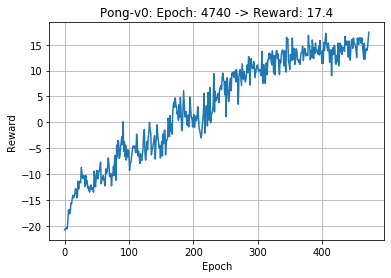

In [0]:
plot(train_epoch, test_rewards, save=True)

**15. Show model in environment**

In [0]:
record_video(ENV_ID, model, video_length=6000, prefix='ppo_pong')

In [0]:
show_videos('PPO_PONG/records/', prefix='ppo_pong')